<a href="https://colab.research.google.com/github/SXV357/Inspirit-AI-Deep-Dive-Designing-DL-Systems-Notebooks/blob/main/Copy_of_Malaria_ML_App.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install pyngrok
!pip -q install streamlit
!pip -q install patool

import cv2
import gdown
import glob
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import patoolib

from joblib import dump
from pyngrok import ngrok
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

DATA_ROOT = '/content'
os.makedirs(DATA_ROOT, exist_ok=True)
max_samples = 3000

blood_slide_url = 'https://drive.google.com/uc?id=1lffxAG8gykh1dh1pCP34uRkH3XMwuNt-'
blood_slide_path = os.path.join(DATA_ROOT, 'blood_slide.jpg')
gdown.download(blood_slide_url, blood_slide_path, True)

!wget "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/malaria_images.zip"
!unzip "malaria_images.zip"
malaria_imgs_path = os.path.join(DATA_ROOT, 'malaria_images.zip')

print("Downloaded Data")

u_malaria_img_paths = glob.glob('/content/malaria_images/Uninfected/*png')
p_malaria_img_paths = glob.glob('/content/malaria_images/Parasitized/*png')

NUM_SAMPLES = len(u_malaria_img_paths) + len(p_malaria_img_paths)

X = []
y = []

X_g = []

for i in tqdm(range(max_samples)):
  img = cv2.imread(u_malaria_img_paths[i])
  X.append(cv2.resize(img,(50,50)))

  gray_img = cv2.imread(u_malaria_img_paths[i],0)
  X_g.append(cv2.resize(gray_img,(50,50)))

  y.append(0)

for i in tqdm(range(max_samples)):
  img = cv2.imread(p_malaria_img_paths[i])
  X.append(cv2.resize(img,(50,50)))

  gray_img = cv2.imread(p_malaria_img_paths[i],0)
  X_g.append(cv2.resize(gray_img,(50,50)))

  y.append(1)

X = np.stack(X)
X_g = np.stack(X_g)
X_reshaped = np.reshape(X_g,(X_g.shape[0],2500))

y = np.array(y)

blood_samples_dir = 'blood_samples'
if (os.path.exists(blood_samples_dir) == False):
  os.mkdir(blood_samples_dir)

for i, img in enumerate(X[2995:3005]):
  plt.imsave('test_img_{}.jpg'.format(i), img)
  
print("Created our X and y variables")

Streaming output truncated to the last 5000 lines.
  inflating: malaria_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: malaria_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: malaria_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: malaria_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: malaria_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: malaria_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: malaria_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
  inflating: malaria_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
  inflating: malaria_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png  
  inflating: malaria_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_87.png  
  inflating: malaria_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_91.png  
  inflating: malaria_images

100%|██████████| 3000/3000 [00:04<00:00, 676.64it/s]


Created our X and y variables


(6000, 50, 50, 3) (6000,)
0


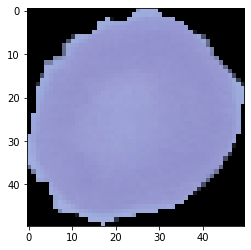

In [2]:
print(X.shape, y.shape)
plt.imshow(X[1])
print(y[1]) # no malaria

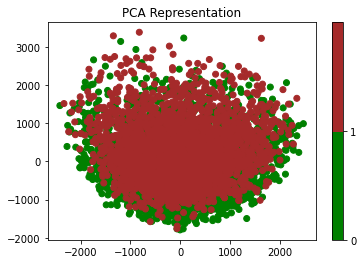

In [3]:
# visualize dataset using pca

pca = PCA(n_components=20)

X_pca = pca.fit_transform(X_reshaped)

colors = ["green","brown"]
classes = [0,1]

plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap=matplotlib.colors.ListedColormap(colors))
cb = plt.colorbar()
loc = np.arange(0,max(y),max(y)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels(classes)
plt.title("PCA Representation")
plt.show()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size = 0.15, random_state = 4)
model = SVC(max_iter = -1, kernel = 'rbf')
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print(f'Accuracy score: {score}') # accuracy score

Accuracy score: 0.6822222222222222


In [5]:
dump(model, "model.joblib")

['model.joblib']

In [6]:
%%writefile app.py
import streamlit as st
from joblib import load
import numpy as np
import cv2

model = load("model.joblib")

st.title('Malaria ML')

uploaded_image = st.file_uploader("Upload Image")
if uploaded_image is not None:
  st.write("Image uploaded successfully")

  file_bytes = np.asarray(bytearray(uploaded_image.read()), dtype=np.uint8)
  image = cv2.imdecode(file_bytes, 1)
  st.image(image, caption="Input Image", channels="BGR")


  small = cv2.resize(image, (50, 50))
  gray = cv2.cvtColor(small, cv2.COLOR_BGR2GRAY)

  image_array = np.reshape(gray, (1, 2500))

  gray_flat = np.reshape(gray,(1,2500))
  prediction = model.predict(gray_flat)[0]

  if prediction == 1:
    st.write('This blood cell is infected with Malaria')
  else:
    st.write('There are no traces of Malaria in this blood cell')

Writing app.py


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
from google.colab import files
!cp /content/drive/MyDrive/ML\ Malaria\ App/creds.py /content

In [11]:
import creds
!ngrok authtoken creds.auth_token

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [12]:
public_url = ngrok.connect(port='80')
print (public_url)
!streamlit run --server.port 80 app.py >/dev/null

NgrokTunnel: "http://4c89-35-234-48-56.ngrok.io" -> "http://localhost:80"
2022-08-14 00:35:28.271 INFO    numexpr.utils: NumExpr defaulting to 2 threads.
